### Link To GitHub Repo: https://github.com/elthran/CSCA-5632

# Book Recommendation System Using Unsupervised Learning

## Step 1: Import Libraries and Load Data

In [151]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

# Display settings for DataFrames
pd.set_option('display.max_columns', 500)
pd.set_option('display.expand_frame_repr', False)

# Load datasets
books = pd.read_csv('data/Books.csv', dtype = {
    'ISBN': str,
    'Book-Title': str,
    'Book-Author': str,
    'Year-Of-Publication': str,  # Use str to handle mixed types
    'Publisher': str,
    'Image-URL-S': str,
    'Image-URL-M': str,
    'Image-URL-L': str
})
users = pd.read_csv('data/Users.csv')
ratings = pd.read_csv('data/Ratings.csv')

In [152]:
## Books (we drop the URLs since we are not advanced enough to use
books = books.drop(columns=["Image-URL-S", "Image-URL-M", "Image-URL-L"])
print("Books:\n", books.head())

Books:
          ISBN                                         Book-Title           Book-Author Year-Of-Publication                   Publisher
0  0195153448                                Classical Mythology    Mark P. O. Morford                2002     Oxford University Press
1  0002005018                                       Clara Callan  Richard Bruce Wright                2001       HarperFlamingo Canada
2  0060973129                               Decision in Normandy          Carlo D'Este                1991             HarperPerennial
3  0374157065  Flu: The Story of the Great Influenza Pandemic...      Gina Bari Kolata                1999        Farrar Straus Giroux
4  0393045218                             The Mummies of Urumchi       E. J. W. Barber                1999  W. W. Norton &amp; Company


In [153]:
## Users
print("Users:\n", users.head())

Users:
    User-ID                            Location   Age
0        1                  nyc, new york, usa   NaN
1        2           stockton, california, usa  18.0
2        3     moscow, yukon territory, russia   NaN
3        4           porto, v.n.gaia, portugal  17.0
4        5  farnborough, hants, united kingdom   NaN


In [154]:
## Ratings
print("Ratings:\n", ratings.head())

Ratings:
    User-ID        ISBN  Book-Rating
0   276725  034545104X            0
1   276726  0155061224            5
2   276727  0446520802            0
3   276729  052165615X            3
4   276729  0521795028            6


## Step 2: Data Inspection

First, we inspect the data types and check for missing values in the datasets.

In [155]:
# Data inspection
print("\nBooks DataFrame Info:")
print(books.info())

print("\nUsers DataFrame Info:")
print(users.info())

print("\nRatings DataFrame Info:")
print(ratings.info())



Books DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
dtypes: object(5)
memory usage: 10.4+ MB
None

Users DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB
None

Ratings DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeInd

Problem data types:

- Books: Year-Of-Publication should be numerical
- Users: User-ID are numerical, which can be fine but I will convert to string (so they are not automatically picked up by numerical operations)
- User: Age should be an integer
- Ratings: User-ID are numerical, which can be fine but I will convert to string (so they are not automatically picked up by numerical operations)

Next check for null values that we will need to deal with

In [156]:
def print_missing_values(df, name):
    # Calculate total missing values for each column
    total_missing = df.isnull().sum()
    # Calculate percentage of missing values for each column
    percent_missing = (total_missing / len(df)) * 100
    # Create a DataFrame with the total and percentage of missing values
    missing_values = pd.DataFrame({'Total Missing': total_missing, 'Percentage Missing': percent_missing})
    # Filter the DataFrame to include only columns with at least one missing value
    missing_values = missing_values[missing_values['Total Missing'] > 0]
    # Print the missing values information
    print(f"\nMissing values in {name} DataFrame:\n", missing_values)
    
print_missing_values(books, "Books")
print_missing_values(users, "Users")
print_missing_values(ratings, "Ratings")



Missing values in Books DataFrame:
              Total Missing  Percentage Missing
Book-Author              2            0.000737
Publisher                2            0.000737

Missing values in Users DataFrame:
      Total Missing  Percentage Missing
Age         110762           39.719857

Missing values in Ratings DataFrame:
 Empty DataFrame
Columns: [Total Missing, Percentage Missing]
Index: []


## Step 3: Data Cleaning

### Fix incorrect book entries

In [157]:
# Let's see why Year was loaded as a string
print("\nAll unique years:\n\n", sorted(books["Year-Of-Publication"].unique()))

print("\n\nBooks with invalid integer years:\n\n", books[books['Year-Of-Publication'].isin(['DK Publishing Inc', 'Gallimard',])])

# There are 3 incorrect entries that need to be fixed
book_correction_mapping = {
    "078946697X": {
        "Year-Of-Publication": "2000",
        "Book-Author": "Teitelbaum, Michael",
        "Publisher": "DK Publishing Inc",
    },
    "2070426769": {
        "Year-Of-Publication": "2003",
        "Book-Author": "Jean-Marie Gustave Le Clézio",
        "Publisher": "Gallimard",
    },
    "0789466953": {
        "Year-Of-Publication": "2000",
        "Book-Author": "Buckley Jr., James; O'Neill",
        "Publisher": "DK Publishing Inc",
    },
}

for isbn, corrected_data in book_correction_mapping.items():
    books.loc[books['ISBN'] == isbn, 'Year-Of-Publication'] = corrected_data['Year-Of-Publication']
    books.loc[books['ISBN'] == isbn, 'Book-Author'] = corrected_data['Book-Author']
    books.loc[books['ISBN'] == isbn, 'Publisher'] = corrected_data['Publisher']



All unique years:

 ['0', '1376', '1378', '1806', '1897', '1900', '1901', '1902', '1904', '1906', '1908', '1909', '1910', '1911', '1914', '1917', '1919', '1920', '1921', '1922', '1923', '1924', '1925', '1926', '1927', '1928', '1929', '1930', '1931', '1932', '1933', '1934', '1935', '1936', '1937', '1938', '1939', '1940', '1941', '1942', '1943', '1944', '1945', '1946', '1947', '1948', '1949', '1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957', '1958', '1959', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2008', '2010', '2011', '2012', '2020', '2021', '2024', '2026', '2030', '2037', '2038', '2050', 'DK Publishing Inc', 'Gallimard']


Books with invali

In [158]:
print("\nAll unique years:\n\n", sorted(books["Year-Of-Publication"].unique()))

# Check the 3 corrected books
books[books['ISBN'].isin(book_correction_mapping.keys())]


All unique years:

 ['0', '1376', '1378', '1806', '1897', '1900', '1901', '1902', '1904', '1906', '1908', '1909', '1910', '1911', '1914', '1917', '1919', '1920', '1921', '1922', '1923', '1924', '1925', '1926', '1927', '1928', '1929', '1930', '1931', '1932', '1933', '1934', '1935', '1936', '1937', '1938', '1939', '1940', '1941', '1942', '1943', '1944', '1945', '1946', '1947', '1948', '1949', '1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957', '1958', '1959', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2008', '2010', '2011', '2012', '2020', '2021', '2024', '2026', '2030', '2037', '2038', '2050']


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...","Teitelbaum, Michael",2000,DK Publishing Inc
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",Jean-Marie Gustave Le Clézio,2003,Gallimard
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...","Buckley Jr., James; O'Neill",2000,DK Publishing Inc


### Fix Null Ages
Since 40% of the ages are NaN and the rest are floats, they are difficult to work with. So we will bin them and make NaN one bin.


In [159]:
# Define the bins and labels for the age ranges
bins = [0, 10, 20, 30, 40, 60, np.inf]
labels = ['0-10', '11-20', '21-30', '31-40', '41-60', '60+']

# Bin the ages using pd.cut
users['Age'] = pd.cut(users['Age'], bins=bins, labels=labels, right=False)
# Handle NaN values by assigning them to a separate bin
users['Age'] = users['Age'].cat.add_categories('Unknown').fillna('Unknown')

# Verify the changes
print("\nBinned ages:\n", users['Age'].value_counts())


Binned ages:
 Age
Unknown    110762
21-30       51539
41-60       45511
31-40       41889
11-20       18894
60+          9194
0-10         1069
Name: count, dtype: int64


Now that the data is corrected, we can set the data types

In [160]:
books["Year-Of-Publication"] = books["Year-Of-Publication"].astype(int)
users['User-ID'] = users['User-ID'].astype(str)
ratings['User-ID'] = ratings['User-ID'].astype(str)

### Clean up User Location

In [161]:
# First let's take a look at them
users["Location"].unique()

array(['nyc, new york, usa', 'stockton, california, usa',
       'moscow, yukon territory, russia', ...,
       'sergnano, lombardia, italy', 'stranraer, n/a, united kingdom',
       'tacoma, washington, united kingdom'], dtype=object)

In [162]:
import re

import pandas as pd
import pycountry
from geopy.exc import GeocoderTimedOut, GeocoderUnavailable
from geopy.geocoders import Nominatim

# Manual corrections for country names
manual_corrections = {
    "russia": "Russian Federation",
    "mxico": "Mexico",
    "turkey": "Türkiye",
    "uae": "United Arab Emirates",
    "espaa": "Spain",
    "uk": "United Kingdom",
}

# Function to get country from location
def get_country_from_location(location, geolocator):
    """
    Extract the country name from a location string.
    
    Args:
    location (str): The location string.
    
    Returns:
    str: The country name if found, else None.
    """
    def strip_special_characters(text):
        # Use regular expression to remove special characters
        return re.sub(r'[^a-zA-Z\s]', '', text)

    def get_official_country_name(country_name):
        for country in pycountry.countries:
            if country_name.lower() in country.name.lower():
                return country.name
        return None

    # Split the location into parts by commas and optional spaces
    parts = re.split(r',\s*', location)

    # Check each part in reverse order to match a country name or alpha_2 code
    for part in parts:
        part = strip_special_characters(part).strip().lower()
        
        # Check manual corrections first
        if part in manual_corrections:
            return manual_corrections[part]
        
        # Try to match country name with pycountry
        try:
            country = pycountry.countries.lookup(part)
            return country.name
        except LookupError:
            continue
    
    for part in parts:
        part = strip_special_characters(part).strip().lower()
        # Try to match country name with geolocator
        try:
            # Geocode the city name
            location = geolocator.geocode(part, timeout=1)
            # If location is found, return the country
            if location:
                location = location.address.split(",")[-1].strip()
                country = pycountry.countries.lookup(location)
                return country.name
            else:
                continue
        except (GeocoderTimedOut, GeocoderUnavailable, TimeoutError):
            # In case of a timeout, retry after a short delay
            continue
        except LookupError:
            return location
    
    # If no part matches a country, return None
    return "Unknown"

# File path for the location-country mapping CSV
mapping_file_path = 'models/location_country_mapping.csv'

# Load existing mappings if available
try:
    existing_mappings = pd.read_csv(mapping_file_path)
    location_to_country = dict(zip(existing_mappings['Location'], existing_mappings['Country']))
    loaded_mappings = True
except FileNotFoundError:
    location_to_country = {}
    loaded_mappings = False

# Initialize the geolocator
geolocator = Nominatim(user_agent="city-to-country-mapper")

# Map each location to its country, checking existing mappings first
def map_location_to_country(location):
    if location in location_to_country:
        return location_to_country[location]
    country = get_country_from_location(location, geolocator)
    location_to_country[location] = country
    return country

users['Country'] = users['Location'].apply(map_location_to_country)

# Save the updated location-country mapping to CSV
updated_mappings = pd.DataFrame(list(location_to_country.items()), columns=['Location', 'Country'])
updated_mappings.to_csv(mapping_file_path, index=False)

# Print the results
print("All countries with people:\n\n", users[users["Country"] != "Unknown"]['Country'].unique().tolist())
print("\n\nUnmapped locations:\n\n", users[users["Country"] == "Unknown"]['Location'].unique().tolist())

# Save the updated mappings for next time
if loaded_mappings is False:
    users[["Location", "Country"]].to_csv("users.csv", index=False)

users = users.drop(columns=['Location'])

All countries with people:

 ['United States', 'Russian Federation', 'Portugal', 'United Kingdom', 'Canada', 'Spain', 'Australia', 'Brazil', 'Germany', 'Mexico', 'Namibia', 'Italy', 'France', 'Georgia', nan, 'Iraq', 'Finland', 'New Zealand', 'India', 'Ghana', 'Netherlands', "Lao People's Democratic Republic", 'Iran, Islamic Republic of', 'Peru', 'Viet Nam', 'Sri Lanka', 'Pakistan', 'Belgium', 'Malaysia', 'United Arab Emirates', 'Türkiye', 'Greece', 'Colombia', 'Norway', 'Kuwait', 'Chile', 'Denmark', 'Sweden', 'Philippines', 'Switzerland', 'Argentina', 'Nigeria', 'Bulgaria', 'Austria', 'Singapore', 'Albania', 'Egypt', 'Tunisia', 'Uzbekistan', 'Qatar', 'Syrian Arab Republic', 'China', 'Saudi Arabia', 'Indonesia', 'Iceland', 'Romania', 'Sudan', 'Macao', 'Thailand', 'Ireland', 'Éire / Ireland', 'Venezuela, Bolivarian Republic of', 'Paraguay', 'Mozambique', 'Morocco', 'Estonia', 'Benin', 'España', 'Österreich', 'Serbia', 'Taiwan, Province of China', 'Poland', 'Slovakia', 'Costa Rica', 'Virg

## Step 4: Visualizations

Distribution of Book Ratings

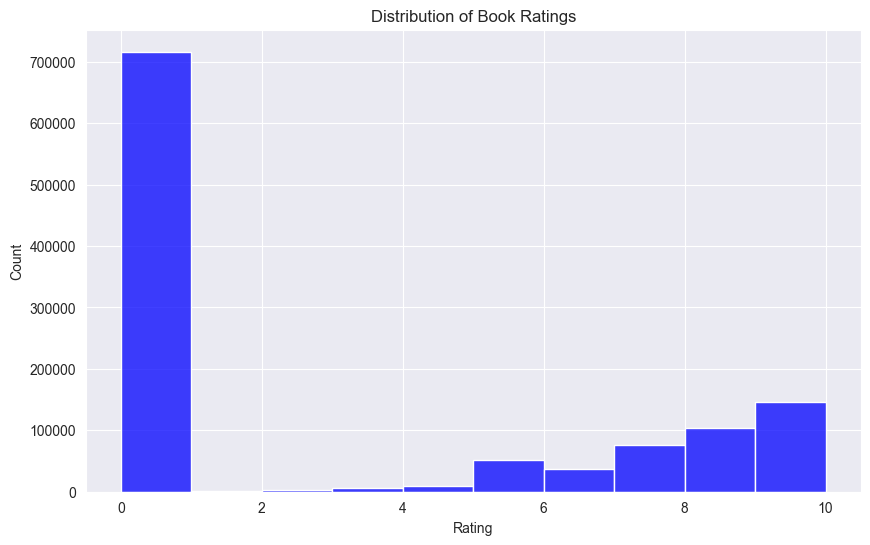

In [163]:
# Visualizing the distribution of book ratings
plt.figure(figsize=(10, 6))
sns.histplot(ratings['Book-Rating'], bins=10, kde=False, color='blue')
plt.title('Distribution of Book Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


Distribution of User Ages


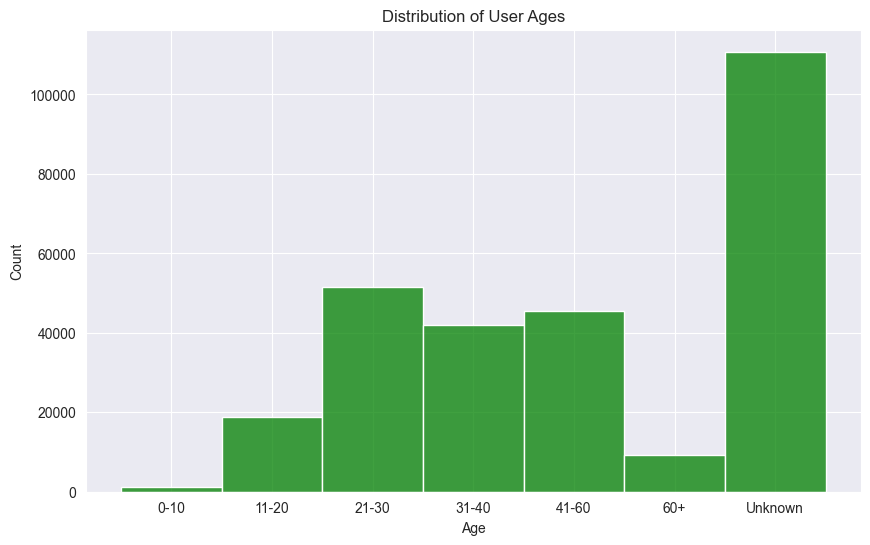

In [164]:
# Visualizing the distribution of user ages
plt.figure(figsize=(10, 6))
sns.histplot(users['Age'].dropna(), bins=30, kde=False, color='green')
plt.title('Distribution of User Ages')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()


Top Publishers


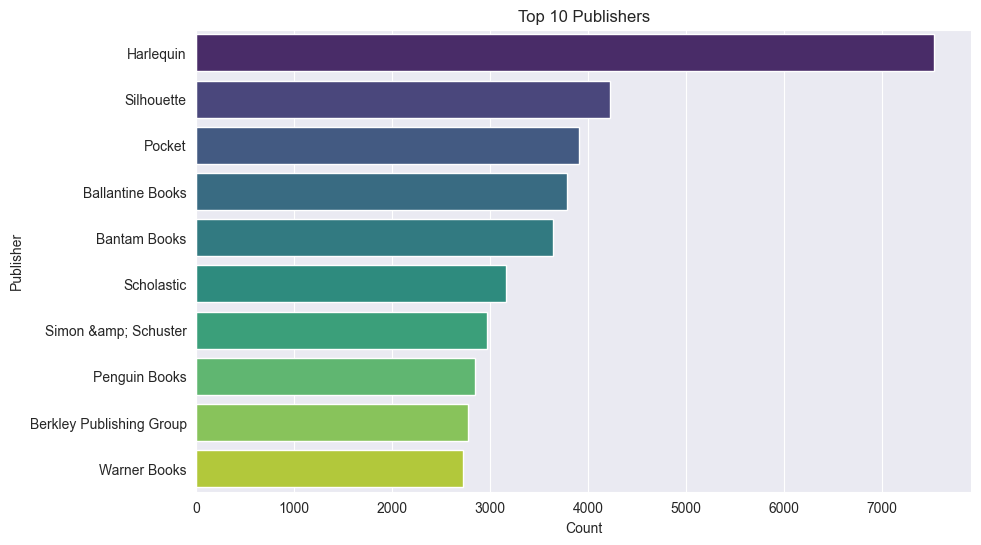

In [165]:
# Visualizing the top publishers
plt.figure(figsize=(10, 6))
top_publishers = books['Publisher'].value_counts().head(10)
sns.barplot(x=top_publishers.values, y=top_publishers.index, palette='viridis', hue=top_publishers.index)
plt.title('Top 10 Publishers')
plt.xlabel('Count')
plt.ylabel('Publisher')
plt.show()


Top Countries

Text(0, 0.5, 'Country')

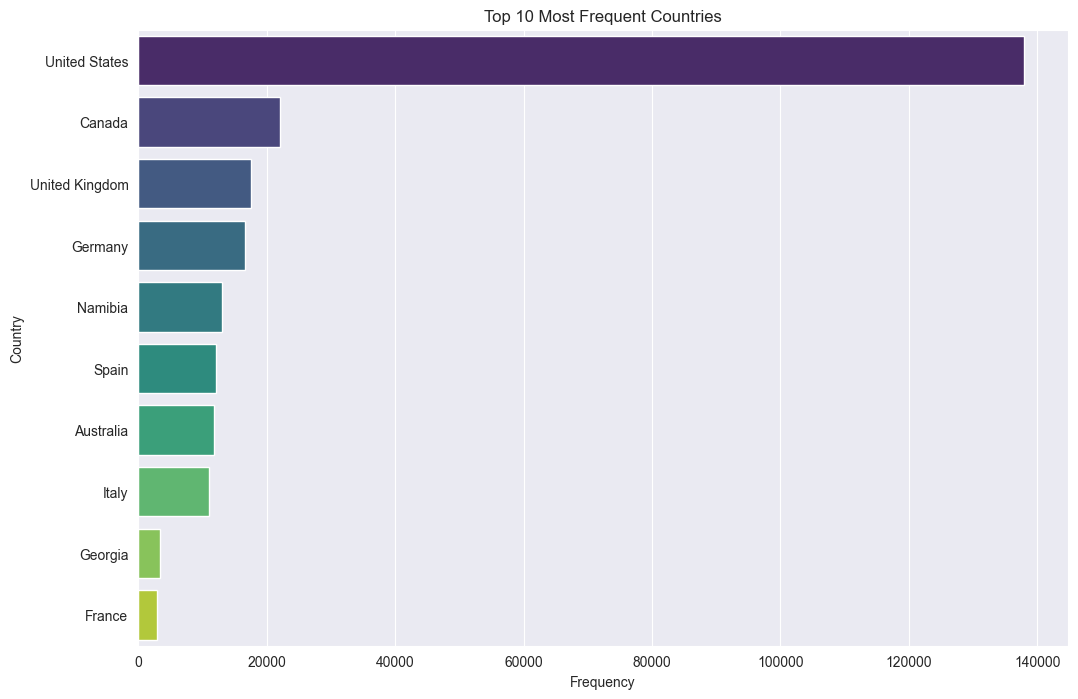

In [166]:
# Visualize the top 10 most frequent countries
top_countries = users['Country'].value_counts().head(10)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_countries.values, y=top_countries.index, palette="viridis", hue=top_countries.index)
plt.title('Top 10 Most Frequent Countries')
plt.xlabel('Frequency')
plt.ylabel('Country')

### Join Books with Ratings to Check Best Rated Books

In [167]:
ratings_books = ratings.merge(books, on='ISBN')

print("Check null column counts to see that all book ratings match to actual books:\n", ratings_books.isnull().sum())

# Calculate the average rating for each book
book_popularity = ratings_books.groupby('ISBN').agg({'Book-Rating': 'mean', 'ISBN': 'count'}).rename(columns={'Book-Rating': 'average_rating', 'ISBN': 'rating_count'})

# Sort by the highest average rating and most ratings
top_books = book_popularity[book_popularity["average_rating"] == 10.0].reset_index()

# Merge with the books dataframe to get book information
top_books_info = top_books.merge(books, on='ISBN')

# Display top books with their information
print("\nThe highest rated books:\n", top_books_info)

Check null column counts to see that all book ratings match to actual books:
 User-ID                0
ISBN                   0
Book-Rating            0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
dtype: int64

The highest rated books:
              ISBN  average_rating  rating_count                                         Book-Title              Book-Author  Year-Of-Publication                      Publisher
0      0001360469            10.0             1                                      Babe Dressing            Mandy Stanley                 1997       HarperCollins Publishers
1      0001374869            10.0             1       Baby Plays (Collins Baby and Toddler Series)            Fiona Pragoff                 1994       HarperCollins Publishers
2      0001821326            10.0             1  Paddington at the Tower (A Paddington Picture ...             Michael Bond                 1976                         Collin
3  

### Examine the Best/Worst Rated Books

In [168]:
# Calculate the highest-rated authors
rated_authors = ratings_books.groupby('Book-Author').agg({'Book-Rating': 'mean', 'Book-Author': 'count'}).rename(columns={'Book-Rating': 'average_rating', 'Book-Author': 'book_count'})
highest_rated_authors = rated_authors[rated_authors["average_rating"] >= 10].sort_values(by=['average_rating', 'book_count'], ascending=[False, False]).reset_index()
lowest_rated_authors = rated_authors[rated_authors["average_rating"] <= 0].sort_values(by=['average_rating', 'book_count'], ascending=[True, False]).reset_index()

# Display top authors with their average ratings
print("\nThe highest rated authors:\n", highest_rated_authors)
print("\nThe lowest rated authors:\n", lowest_rated_authors)

# Calculate the highest-rated publishers
rated_publishers = ratings_books.groupby('Publisher').agg({'Book-Rating': 'mean', 'Publisher': 'count'}).rename(columns={'Book-Rating': 'average_rating', 'Publisher': 'book_count'})
highest_rated_publishers = rated_publishers[rated_publishers["average_rating"] >= 10].sort_values(by=['average_rating', 'book_count'], ascending=[False, False]).reset_index()
lowest_rated_publishers = rated_publishers[rated_publishers["average_rating"] <= 0].sort_values(by=['average_rating', 'book_count'], ascending=[True, False]).reset_index()

# Display top publishers with their average ratings
print("\nThe highest rated publishers:\n", highest_rated_publishers)
print("\nThe lowest rated publishers:\n", lowest_rated_publishers)


The highest rated authors:
                           Book-Author  average_rating  book_count
0                      Michiro Ueyama            10.0          13
1                    David R. Hawkins            10.0           7
2                         Dick Dudley            10.0           6
3     Federal Aviation Administration            10.0           6
4                Laura Numeroff Joffe            10.0           6
...                               ...             ...         ...
5012                 Zohra Greenhalgh            10.0           1
5013                    e.e. cummings            10.0           1
5014                    johanna spyri            10.0           1
5015               of Padua Marsilius            10.0           1
5016                  retold by Dandi            10.0           1

[5017 rows x 3 columns]

The lowest rated authors:
                Book-Author  average_rating  book_count
0             Dick Stivers             0.0          60
1           Yvon

## Feature Importance Hypothesis

- **User Age:** Age might influence book preferences.
- **Book Author and Publisher:** Popular authors and publishers might have higher ratings.
- **User Location:** Geographical location might impact book preferences.

These hypotheses will be validated during the model building and evaluation phase.


## Conclusion of EDA

### Data Purity and Concerns
The main areas of concern after EDA is that our only knowledge about the users is 'age' and 'location', but 'age' has 40% null and location is inconsistent. So we will need to be careful about how we map users together.
Additionally, the rating data is split between 'explicit' (1-10) [user chose the rating] ratings and implicit (0, 5, 10) [system chose based on action] depending on the data source. So we will likely need to run our models on both rating types.

### Distribution of Book Ratings
The distribution of book ratings is highly skewed, with the majority of ratings being zero. This indicates that many users have rated very few books.

### Distribution of User Ages
The age distribution of users shows a diverse range of ages, with notable peaks in the 21-30 and 31-40 age groups. Additionally, a significant portion of the users did not provide their age, which is represented as 'Unknown'.

### Top Publishers
The dataset contains books from a wide variety of publishers. The top 10 publishers, led by Harlequin, have published a significant number of books in the dataset.

### Top Countries
The dataset contains books from all over the world, but it skews heavily towards USA.

### Best/Worst Rated Books
Many tens of thousands of books only have 10 or 0 for their rating. In fact, many tens of thousands of Publishers have only ever received a 0 or 10 for all of their books.
So the rating system may not be perfectly capturing a varied opinion on the books and likely have small sample sizes.


### Summary of Findings
Book Ratings Distribution: The ratings data is heavily skewed towards zero, suggesting that a large number of users have not rated many books. This could impact the recommendation system, and we may need to consider strategies to handle this sparsity.

### User Distribution: 
The age data is diverse but has a significant number of missing values. For those who provided their age, the majority fall into the 21-30 and 31-40 age brackets. This information might help in understanding user preferences based on age groups. We have shifted the location granularity to country and will try to use that as a feature.

### Top Publishers: 
Harlequin is the most prolific publisher in the dataset, followed by Silhouette and Pocket. Understanding the distribution of publishers can help in identifying popular books and trends.

### Next Steps
Based on the insights from the EDA, the next steps will involve:

Handling missing values [especially with age] and outliers in the dataset.
Exploring various unsupervised learning techniques, such as clustering, to group similar books and users.
Building a book recommendation system and evaluating its performance.
By addressing these aspects, we can ensure that our recommendation system is robust and effective in providing meaningful recommendations to users.


# Step 5: Analysis Using Unsupervised ML Models

Filter our data 

First create a rating_matrix

In [169]:
# Merge ratings with books and users data
ratings = ratings.merge(books, on='ISBN', how='left')
ratings = ratings.merge(users, on='User-ID', how='left')

# Fill missing ratings with the mean rating of each user
ratings['Book-Rating'] = ratings.groupby('User-ID')['Book-Rating'].transform(lambda x: x.fillna(x.mean()))

# Split the ratings data into train and test
train, test = train_test_split(ratings, test_size=0.2, random_state=42)

# Normalize ratings by subtracting mean user ratings
def normalize_ratings(rating_matrix_df):
    return rating_matrix_df.apply(lambda x: x - x.mean(), axis=1)

def filter_out_books_in_training(train_):
    """
    Filter out books and users that do not have enough ratings.

    Args:
    train_ (pd.DataFrame): The training data.

    Returns:
    pd.DataFrame: Filtered training data.
    """
    # Books that have not been rated enough times will not be used in training
    book_ratings_count = train_.groupby('Book-Title').count()['Book-Rating']
    popular_books = book_ratings_count[book_ratings_count >= 200].index
    train_ = train_[train_['Book-Title'].isin(popular_books)]
    
    # Users who have not rated enough books will not have their ratings used in training
    user_ratings_count = train.groupby('User-ID').count()['Book-Rating']
    active_users = user_ratings_count[user_ratings_count > 5].index
    train_ = train_[train_['User-ID'].isin(active_users)]
    
    print("Number of Ratings in Filtered Train:\n", len(train_.index))
    
    return train_

def get_rating_matrix_df(train_, filtered=False):
    """
    Create and return a rating matrix DataFrame, optionally filtered and saved as a Parquet file.

    Args:
    train_ (pd.DataFrame): The training data.
    filtered (bool): Flag to determine if the data should be filtered.

    Returns:
    pd.DataFrame: The rating matrix DataFrame.
    """
    if filtered:
        parquet_file_path = "models/rating_matrix_filtered.parquet"
    else:
        parquet_file_path = "models/rating_matrix.parquet"
    
    # Check if the Parquet file already exists
    if os.path.exists(parquet_file_path):
        # Load the pivot table from the Parquet file
        rating_matrix_df = pd.read_parquet(parquet_file_path)
    else:
        # Create the utility matrix for collaborative filtering, filling missing values with the mean rating of each user
        if filtered:
            train_ = filter_out_books_in_training(train_)
        rating_matrix_df = train_.pivot(index='User-ID', columns='ISBN', values='Book-Rating')
        # rating_matrix_df = rating_matrix_df.apply(lambda x: x.fillna(5), axis=1)
        rating_matrix_df = rating_matrix_df.apply(lambda x: x.fillna(x.mean()), axis=1)
                
        # Save the pivot table to a Parquet file for faster loading next time
        rating_matrix_df.to_parquet(parquet_file_path)
        
    return rating_matrix_df

def get_rating_matrix_sparse(df_):
    # Convert the DataFrame to a sparse matrix
    return csr_matrix(df_.values)

In [170]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, precision_score, recall_score, f1_score


# Create a model evaluation function
def evaluate_model(cf_model, test):
    y_true = []
    y_pred = []
    
    # Iterate through the test set
    for _, row in test.iterrows():
        user_id = row['User-ID']
        book_id = row['ISBN']
        true_rating = row['Book-Rating']
        predicted_rating = cf_model.predict_rating(user_id, book_id)
        
        # Collect ratings if the prediction is valid
        if not np.isnan(predicted_rating):
            y_true.append(true_rating)
            y_pred.append(predicted_rating)
    
    # Calculate RMSE
    rmse = np.sqrt(root_mean_squared_error(y_true, y_pred))
    # Calculate MAE
    mae = mean_absolute_error(y_true, y_pred)
    
    # Convert true and predicted ratings to binary relevance for precision and recall
    y_true_binary = [1 if rating >= 4 else 0 for rating in y_true]
    y_pred_binary = [1 if rating >= 4 else 0 for rating in y_pred]
    
    # Calculate Precision
    precision = precision_score(y_true_binary, y_pred_binary, zero_division=1)
    # Calculate Recall
    recall = recall_score(y_true_binary, y_pred_binary, zero_division=1)
    # Calculate F1-score
    f1 = f1_score(y_true_binary, y_pred_binary, zero_division=1)
    
    # Return results as a dictionary
    return {
        'rmse': rmse,
        'mae': mae,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

# accounts/views.py
def print_evaluation_metrics(model_name, evaluation):
    # Print the evaluation metrics with appropriate formatting
    print(f"{model_name} Evaluation Metrics:")
    print(f"{'Root Mean Squared Error (RMSE):':<30} {evaluation['rmse']:.2f}")
    print(f"{'Mean Absolute Error (MAE):':<30} {evaluation['mae']:.2f}")
    print(f"{'Precision:':<30} {evaluation['precision']:.2%}")
    print(f"{'Recall:':<30} {evaluation['recall']:.2%}")
    print(f"{'F1-score:':<30} {evaluation['f1_score']:.2%}")
    print("-" * 40)

In [171]:
class CollaborativeFiltering:
    def __init__(self, train_, similarity_file='models/user_similarity.pkl'):
        self.rating_matrix_df = get_rating_matrix_df(train_, filtered=True)  # DataFrame for index lookups
        self.rating_matrix_df = normalize_ratings(self.rating_matrix_df)
        self.rating_matrix_sparse = get_rating_matrix_sparse(self.rating_matrix_df)  # Sparse matrix for calculations

        self.similarity_file = similarity_file

        # Check if the user similarity matrix is already saved
        try:
            self.user_similarity = joblib.load(similarity_file)
            print("User similarity matrix loaded from file.")
        except:
            print("Calculating user similarity matrix...")
            # Compute the user similarity matrix using cosine similarity on sparse matrix
            self.user_similarity = cosine_similarity(self.rating_matrix_sparse)
            # Fill diagonal with zeros to avoid self-recommendation
            np.fill_diagonal(self.user_similarity, 0)
            # Save the similarity matrix to disk
            joblib.dump(self.user_similarity, similarity_file)
            print("User similarity matrix saved to file.")

    def predict_rating(self, user_id, book_id):
        # Check if the user and book are in the training data
        if user_id not in self.rating_matrix_df.index or book_id not in self.rating_matrix_df.columns:
            return np.nan
        # Get the index of the user and book
        user_index = self.rating_matrix_df.index.get_loc(user_id)
        book_index = self.rating_matrix_df.columns.get_loc(book_id)
        # Get the similarity scores for this user
        similarity_scores = self.user_similarity[user_index]
        # Get the ratings for the target book from all users
        book_ratings = self.rating_matrix_df.iloc[:, book_index].values
        # Mask to consider only users who have rated the book
        mask = book_ratings != 0
        # Calculate the weighted sum of ratings
        weighted_sum = np.dot(similarity_scores[mask], book_ratings[mask])
        # Sum of similarities
        sum_of_similarities = np.sum(similarity_scores[mask])
        if sum_of_similarities == 0:
            return np.nan
        # Predicted rating
        predicted_rating = weighted_sum / sum_of_similarities
        return predicted_rating

    def recommend(self, user_id, n_recommendations=5):
        # Get the index of the user
        user_index = self.rating_matrix_df.index.get_loc(user_id)
        # Get the similarity scores for this user
        similarity_scores = self.user_similarity[user_index]
        # Get the indices of the most similar users
        similar_users = similarity_scores.argsort()[::-1][:n_recommendations]
        # Get the book ratings from similar users
        similar_users_ratings = self.rating_matrix_df.iloc[similar_users]
        # Compute the mean ratings for each book, ignoring 0 values
        mean_ratings = similar_users_ratings.replace(0, np.nan).mean(axis=0)
        # Sort the books by mean rating
        recommended_books = mean_ratings.sort_values(ascending=False).index.tolist()
        return recommended_books[:n_recommendations]

# Instantiate the collaborative filtering model
cf_model = CollaborativeFiltering(train)

# Calculate RMSE on the test set
collab_rmse = evaluate_model(cf_model, test)
print("Accuracy Metrics for Collaborative Filtering Model on the test set:", collab_rmse)

Number of Ratings in Filtered Train:
 48247
Calculating user similarity matrix...
User similarity matrix saved to file.
Accuracy Metrics for Collaborative Filtering Model on the test set: {'rmse': np.float64(5.508627715504256), 'mae': np.float64(4.691524614677275), 'precision': np.float64(0.42105263157894735), 'recall': np.float64(0.038129282097110515), 'f1_score': np.float64(0.06992624965856323)}


In [172]:
class GlobalAverageModel:
    def __init__(self, train_):
        rating_matrix_df = get_rating_matrix_df(train_, filtered=True)
        # Flatten the DataFrame values and exclude NaNs to calculate the global mean
        rating_matrix_flat = rating_matrix_df.values.flatten()
        self.global_mean = np.nanmean(rating_matrix_flat)

    def predict_rating(self, user_id, book_id):
        return self.global_mean

    def recommend(self, user_id, n_recommendations=5):
        return [self.global_mean] * n_recommendations

# Instantiate the global average model
global_avg_model = GlobalAverageModel(train)

# Evaluate the global average model using RMSE on the test set
rmse_global_avg = evaluate_model(global_avg_model, test)
print("Accuracy Metrics for Global Average Model on the test set:", rmse_global_avg)

Accuracy Metrics for Global Average Model on the test set: {'rmse': np.float64(1.9866970119877823), 'mae': np.float64(3.804870943742836), 'precision': np.float64(1.0), 'recall': np.float64(0.0), 'f1_score': np.float64(0.0)}


In [173]:
class UserAverageModel:
    def __init__(self, train_):
        rating_matrix_df = get_rating_matrix_df(train_, filtered=True)
        
        # Calculate the mean rating per user, excluding NaNs
        self.user_means = rating_matrix_df.mean(axis=1)

    def predict_rating(self, user_id, book_id):
        if user_id in self.user_means:
            return self.user_means[user_id]
        else:
            return np.nan

    def recommend(self, user_id, n_recommendations=5):
        if user_id in self.user_means:
            return [self.user_means[user_id]] * n_recommendations
        else:
            return [np.nan] * n_recommendations

# Instantiate the user average model
user_avg_model = UserAverageModel(train)

# Evaluate the user average model using RMSE on the test set
rmse_user_avg = evaluate_model(user_avg_model, test)
print("Accuracy Metrics for User Average Model on the test set:", rmse_user_avg)


Accuracy Metrics for User Average Model on the test set: {'rmse': np.float64(1.9218792764754606), 'mae': np.float64(2.7392098741506956), 'precision': np.float64(0.5668885304740919), 'recall': np.float64(0.4687793515422474), 'f1_score': np.float64(0.5131869826744127)}


In [174]:
class ItemAverageModel:
    def __init__(self, train_):
        rating_matrix_df = get_rating_matrix_df(train_, filtered=True)
        
        # Calculate the mean rating per item (book), excluding NaNs
        self.item_means = rating_matrix_df.mean(axis=0)

    def predict_rating(self, user_id, book_id):
        if book_id in self.item_means:
            return self.item_means[book_id]
        else:
            return np.nan

    def recommend(self, user_id, n_recommendations=5):
        if book_id in self.item_means:
            return [self.item_means[book_id]] * n_recommendations
        else:
            return [np.nan] * n_recommendations

# Instantiate the item average model
item_avg_model = ItemAverageModel(train)

# Evaluate the item average model using RMSE on the test set
rmse_item_avg = evaluate_model(item_avg_model, test)
print("Accuracy Metrics for Item Average Model on the test set:", rmse_item_avg)


Accuracy Metrics for Item Average Model on the test set: {'rmse': np.float64(2.015863410721972), 'mae': np.float64(3.9097717061533412), 'precision': np.float64(1.0), 'recall': np.float64(0.0), 'f1_score': np.float64(0.0)}


In [175]:
class RandomModel:
    def __init__(self, train_):
        rating_matrix_df = get_rating_matrix_df(train_, filtered=True)
        
        # Flatten the DataFrame values and exclude NaNs to calculate min and max ratings
        rating_matrix_flat = rating_matrix_df.values.flatten()
        self.min_rating = np.nanmin(rating_matrix_flat)
        self.max_rating = np.nanmax(rating_matrix_flat)

    def predict_rating(self, user_id, book_id):
        return np.random.uniform(self.min_rating, self.max_rating)

    def recommend(self, user_id, n_recommendations=5):
        return [np.random.uniform(self.min_rating, self.max_rating) for _ in range(n_recommendations)]

# Instantiate the random model
random_model = RandomModel(train)

# Evaluate the random model using RMSE on the test set
rmse_random = evaluate_model(random_model, test)
print("Accuracy Metrics for Random Model on the test set:", rmse_random)


Accuracy Metrics for Random Model on the test set: {'rmse': np.float64(2.295436862395513), 'mae': np.float64(4.441348587857742), 'precision': np.float64(0.3674981530572335), 'recall': np.float64(0.5998439476515304), 'f1_score': np.float64(0.45576749471150174)}


In [176]:
from scipy.sparse.linalg import svds


def grid_search_k(train, test, k_values, reg_values):
    """
    Perform grid search to find the optimal number of latent factors (k) and regularization (reg) for SVD.

    Args:
    train (pd.DataFrame): The training dataset.
    test (pd.DataFrame): The test dataset.
    k_values (list): List of k values to evaluate.
    reg_values (list): List of regularization values to evaluate.

    Returns:
    dict: Dictionary with (k, reg) as keys and RMSE/MAE/R^2 scores as values.
    """
    results = {}
    for k in k_values:
        for reg in reg_values:
            print(f"Evaluating k={k}, reg={reg}...")
            svd_model = SVDFiltering(train, k, reg)
            accuracy_metrics = evaluate_model(svd_model, test)
            results[(k, reg)] = accuracy_metrics
            print(f"k={k}, reg={reg}:", accuracy_metrics)
    return results


class SVDFiltering:
    def __init__(self, train_, k_, reg):
        self.rating_matrix_df = get_rating_matrix_df(train_, filtered=True)  # DataFrame for index lookups
        self.rating_matrix_df, self.user_means = self.normalize_ratings(self.rating_matrix_df)
        self.rating_matrix_sparse = get_rating_matrix_sparse(self.rating_matrix_df)  # Sparse matrix for calculations
        
        # Use SVD for dimensionality reduction
        self.U, self.sigma, self.Vt = svds(self.rating_matrix_sparse, k=k_)
        self.sigma = np.diag(self.sigma)

        # Regularization parameter
        self.reg = reg

    def normalize_ratings(self, rating_matrix_df):
        """
        Normalize the ratings by subtracting the mean rating for each user.

        Args:
        rating_matrix_df (pd.DataFrame): The user-item rating matrix.

        Returns:
        pd.DataFrame: The normalized user-item rating matrix.
        pd.Series: The mean ratings for each user.
        """
        user_means = rating_matrix_df.mean(axis=1)
        rating_matrix_normalized = rating_matrix_df.sub(user_means, axis=0)
        return rating_matrix_normalized, user_means

    def predict_rating(self, user_id, book_id):
        if user_id not in self.rating_matrix_df.index or book_id not in self.rating_matrix_df.columns:
            return np.nan
        user_index = self.rating_matrix_df.index.get_loc(user_id)
        book_index = self.rating_matrix_df.columns.get_loc(book_id)
        
        user_predicted_ratings = np.dot(np.dot(self.U[user_index, :], self.sigma), self.Vt)
        # Adjust prediction by adding the user mean and applying regularization
        predicted_rating = user_predicted_ratings[book_index] + self.user_means[user_id] * self.reg
        
        return predicted_rating

    def recommend(self, user_id, n_recommendations=5):
        if user_id not in self.rating_matrix_df.index:
            return []

        user_index = self.rating_matrix_df.index.get_loc(user_id)
        user_predicted_ratings = np.dot(np.dot(self.U[user_index, :], self.sigma), self.Vt)
        
        # Adjust predictions by adding the user mean
        user_predicted_ratings += self.user_means[user_index]
        
        # Get indices of books the user has not rated yet
        unrated_books_indices = np.where(self.rating_matrix_df.loc[user_id].isna())[0]
        
        # Sort the predicted ratings for these unrated books
        recommended_books_indices = np.argsort(user_predicted_ratings[unrated_books_indices])[::-1]
        
        # Get the actual book IDs for these indices
        recommended_books = self.rating_matrix_df.columns[unrated_books_indices][recommended_books_indices].tolist()
        
        return recommended_books[:n_recommendations]

# Instantiate the SVD-based collaborative filtering model
results = grid_search_k(train, test, k_values=[10, 50, 100], reg_values=[0.6, 0.8, 1.0])

# Find the best k based on RMSE
best_results = max(results, key=lambda x: results[x]['f1_score'])
svd_rmse = results[best_results]

# Evaluate the SVD-based collaborative filtering model
print(f"Best results with k={best_results[0]} and reg={best_results[1]}")
print("Accuracy Metrics for SVD-based Collaborative Filtering Model on the test set:", svd_rmse)


Evaluating k=10, reg=0.6...
k=10, reg=0.6: {'rmse': np.float64(1.968584482992831), 'mae': np.float64(2.901994693823562), 'precision': np.float64(0.7191011235955056), 'recall': np.float64(0.222001982160555), 'f1_score': np.float64(0.339265429761454)}
Evaluating k=10, reg=0.8...
k=10, reg=0.8: {'rmse': np.float64(1.9436554803401176), 'mae': np.float64(2.905946585775243), 'precision': np.float64(0.6550106609808103), 'recall': np.float64(0.38057482656095143), 'f1_score': np.float64(0.48142924306535023)}
Evaluating k=10, reg=1.0...
k=10, reg=1.0: {'rmse': np.float64(1.9603566277628242), 'mae': np.float64(2.9710517219727643), 'precision': np.float64(0.6098074608904934), 'recall': np.float64(0.5022299306243806), 'f1_score': np.float64(0.5508152173913043)}
Evaluating k=50, reg=0.6...
k=50, reg=0.6: {'rmse': np.float64(1.9698683163302815), 'mae': np.float64(2.903619077249025), 'precision': np.float64(0.7203791469194313), 'recall': np.float64(0.2259663032705649), 'f1_score': np.float64(0.3440211

In [177]:
print("RMSE Comparison:")

print(rmse_random)
print(svd_rmse)

print(print_evaluation_metrics("Random Model:", rmse_random))
print(print_evaluation_metrics("Global Average Model:", rmse_global_avg))
print(print_evaluation_metrics("User Average Model:", rmse_user_avg))
print(print_evaluation_metrics("Item Average Model:", rmse_item_avg))
print(print_evaluation_metrics("Collaborative Filtering Model:", collab_rmse))
print(print_evaluation_metrics("SVD-based Collaborative Filtering Model:", svd_rmse))

RMSE Comparison:
{'rmse': np.float64(2.295436862395513), 'mae': np.float64(4.441348587857742), 'precision': np.float64(0.3674981530572335), 'recall': np.float64(0.5998439476515304), 'f1_score': np.float64(0.45576749471150174)}
{'rmse': np.float64(1.9615763989087833), 'mae': np.float64(2.969828881907312), 'precision': np.float64(0.608656981915209), 'recall': np.float64(0.5086719524281467), 'f1_score': np.float64(0.554190848967472)}
Random Model: Evaluation Metrics:
Root Mean Squared Error (RMSE): 2.30
Mean Absolute Error (MAE):     4.44
Precision:                     36.75%
Recall:                        59.98%
F1-score:                      45.58%
----------------------------------------
None
Global Average Model: Evaluation Metrics:
Root Mean Squared Error (RMSE): 1.99
Mean Absolute Error (MAE):     3.80
Precision:                     100.00%
Recall:                        0.00%
F1-score:                      0.00%
----------------------------------------
None
User Average Model: Eval